A.S. Lundervold, v.181022

# Introduction

This notebooks continues where `1.0-asl-nnets_building_blocks_part1.ipynb` left off, showcasing some modern techniques from image classification. 

> **Note:** The notebook doesn't contain a lot of details. In the lecture, we'll talk more about each step.

We'll use the `fastai` deep learning library:

<img width=15% src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmxUrCRPBipwj-orodQiF13-ulBr2BOZ0fhA&usqp=CAU">

## Some technical details about `fastai`

The fastai docs are quite good: https://docs.fast.ai/

You may also want to have a look at their paper _fastai: A Layered API for Deep Learning_ for details about the design of `fastai`: https://arxiv.org/abs/2002.04688

<img width=40% src="https://docs.fast.ai/images/layered.png">

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or on Kaggle, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
try:
    import colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
if (colab or kaggle):
    !pip3 install -U fastai

In [4]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from pathlib import Path

from fastai.vision.all import *

In [5]:
NB_DIR = Path.cwd()
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATADIR = Path("/content/gdrive/MyDrive/Colab Notebooks/data")
    DATADIR.mkdir(exist_ok=True)
if not colab:
    DATADIR = Path.home()/'data' # You can change this if you want to store data elsewhere
    DATADIR.mkdir(exist_ok=True)

# Load the data

In [6]:
path = untar_data(URLs.IMAGENETTE_160)

In [7]:
path.ls()

(#4) [Path('/home/ubuntu/.fastai/data/imagenette2-160/.DS_Store'),Path('/home/ubuntu/.fastai/data/imagenette2-160/noisy_imagenette.csv'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train'),Path('/home/ubuntu/.fastai/data/imagenette2-160/val')]

In [8]:
fnames = get_image_files(path)

In [9]:
fnames

(#13394) [Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_954.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_4705.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1096.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_7594.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_2395.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1263.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_5156.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1055.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_2644.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_919.JPEG')...]

In [10]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [11]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

## Dataloaders

In [12]:
def get_dataloaders(sz=128, bs=64, batch_tfms=None):
    dblock = DataBlock(
                blocks=(ImageBlock, CategoryBlock()),
                get_items=get_image_files,
                get_y=label_func,
                item_tfms=Resize(sz),
                batch_tfms=batch_tfms)
    
    dls = dblock.dataloaders(path, bs=bs)
    return dls

In [13]:
dls = get_dataloaders()

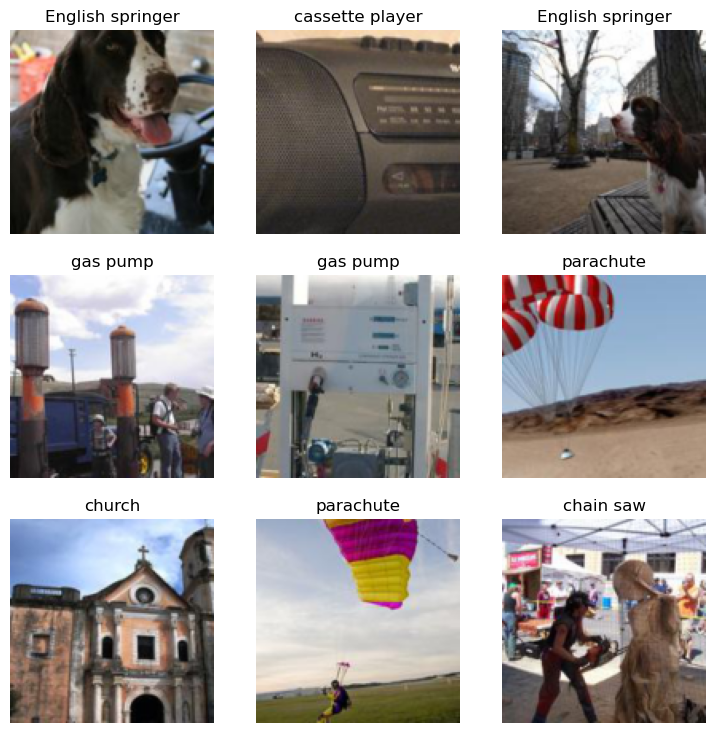

In [14]:
dls.show_batch()

## Data augmentation

### Basic transformations

In [15]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            Normalize.from_stats(*imagenet_stats)]

### Test the effect

In [16]:
dls = get_dataloaders(batch_tfms=batch_tfms)

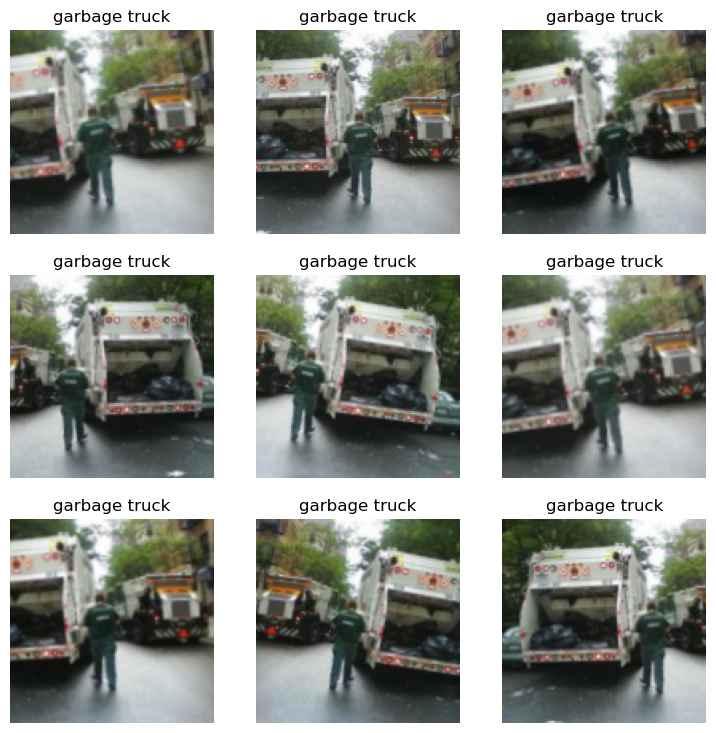

In [17]:
dls.show_batch(unique=True)

### RandomErasing

In [18]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            RandomErasing(), 
            Normalize.from_stats(*imagenet_stats)]

In [19]:
dls = get_dataloaders(batch_tfms=batch_tfms)

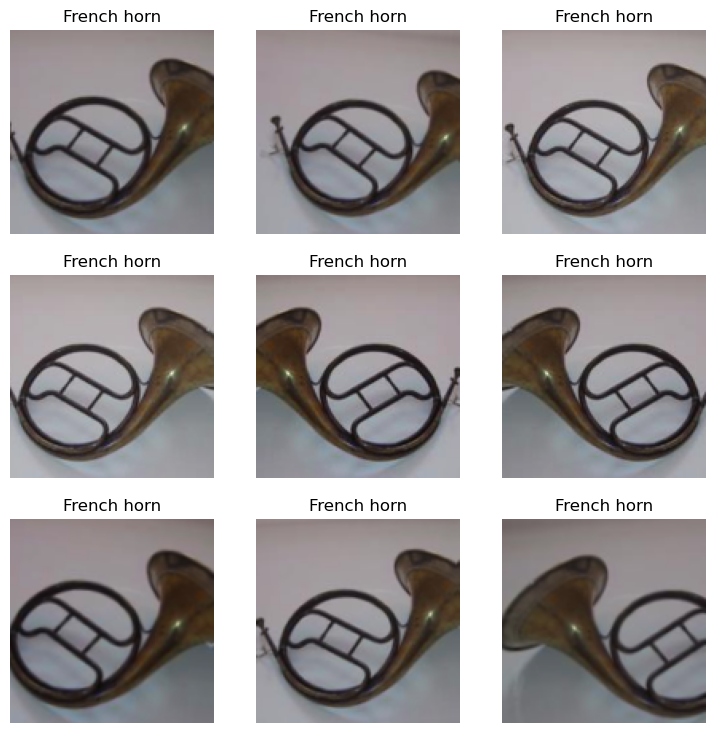

In [20]:
dls.show_batch(unique=True)

In [21]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            RandomErasing(), 
            RandomResizedCrop(128),
            Normalize.from_stats(*imagenet_stats)]

In [22]:
dls = get_dataloaders(batch_tfms=batch_tfms)

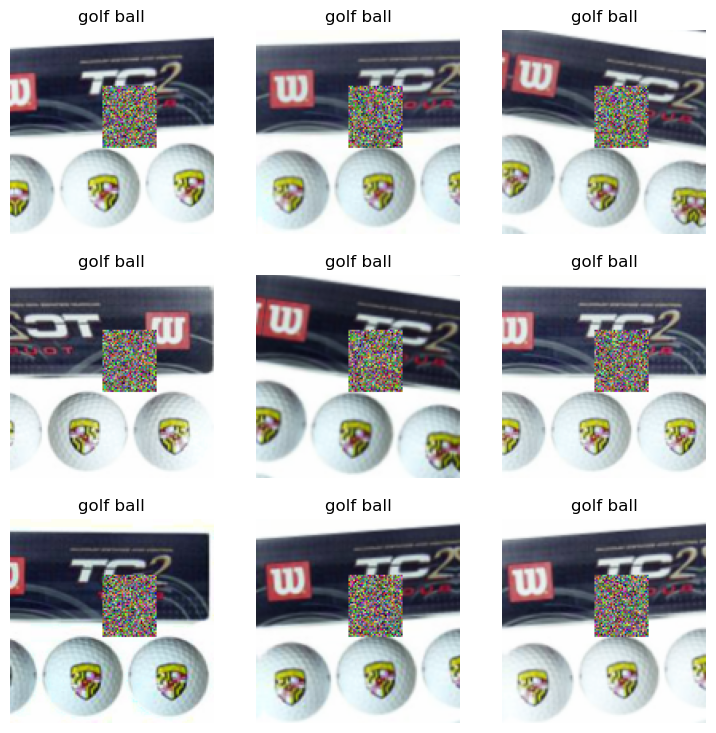

In [23]:
dls.show_batch(unique=True)

### MixUp and CutMix

<img width=80% src="assets/mixup.png">

<img width=80% src="assets/cutmix.png">

<img src="assets/mixup-cutmix.png">

<img src="assets/mixup2.png">

In [24]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            Normalize.from_stats(*imagenet_stats)]

In [25]:
dls = get_dataloaders(batch_tfms=batch_tfms)

In [26]:
mixup = MixUp(alpha=1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn_m:
    learn_m.epoch,learn_m.training = 0,True
    learn_m.dl = dls.train
    b = dls.one_batch()
    learn_m._split(b)
    learn_m('before_train')
    learn_m('before_batch')

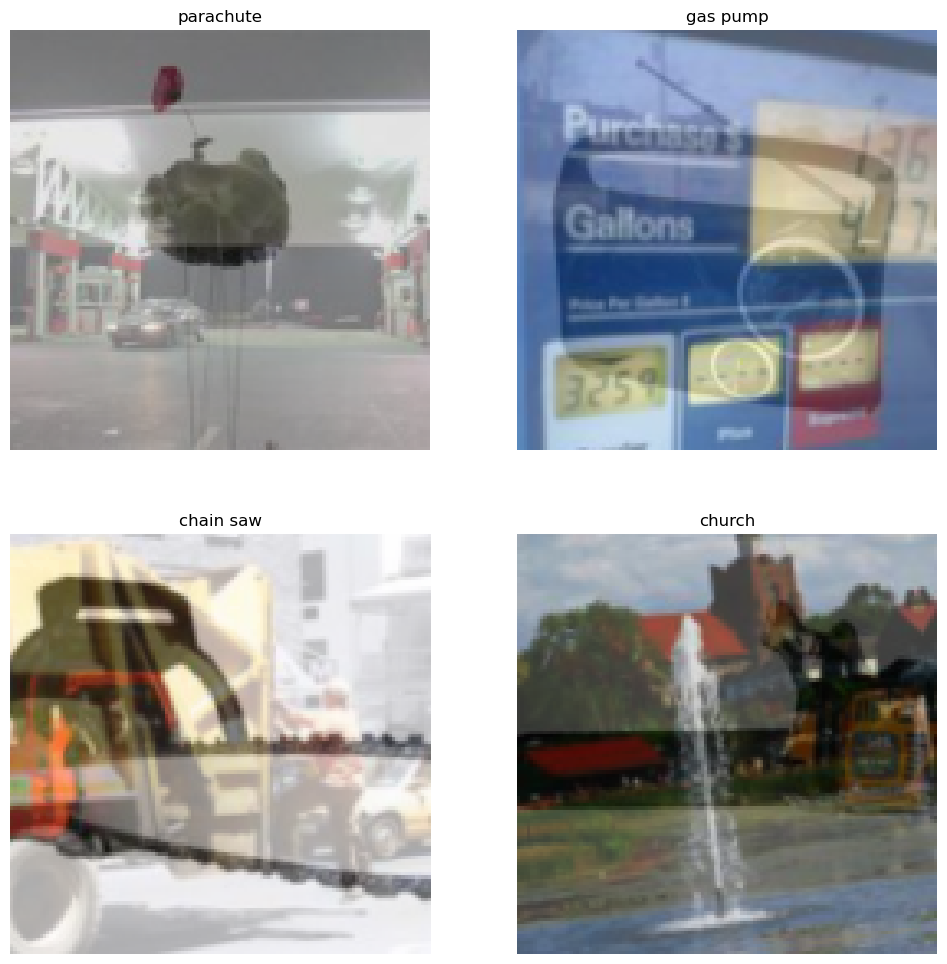

In [27]:
_,axs = plt.subplots(2,2, figsize=(12,12))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [28]:
cutmix = CutMix(alpha=1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn_c:
    learn_c.epoch,learn_c.training = 0,True
    learn_c.dl = dls.train
    b = dls.one_batch()
    learn_c._split(b)
    learn_c('before_train')
    learn_c('before_batch')

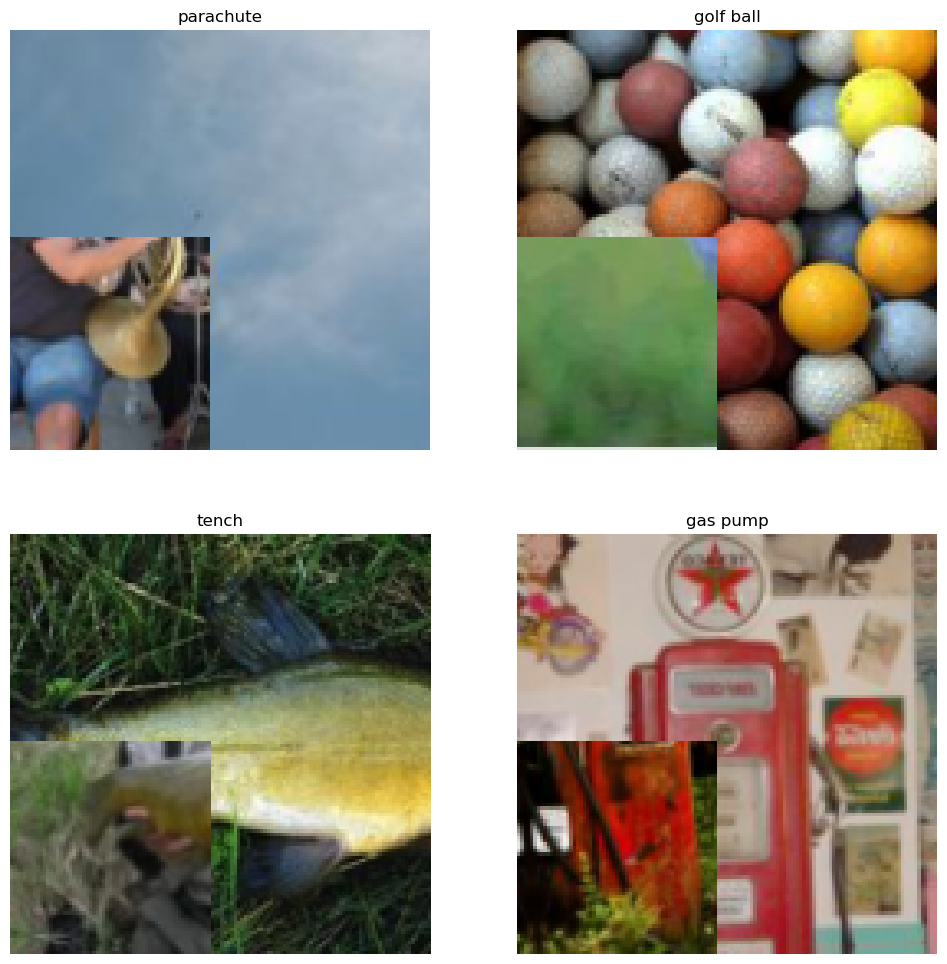

In [29]:
_,axs = plt.subplots(2,2, figsize=(12,12))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

# Models

In [30]:
dls = get_dataloaders(sz=128, bs=64, batch_tfms=batch_tfms)

In [31]:
learn = Learner(
    dls, xresnet34(n_out=10),
    metrics=[accuracy, RocAuc(), F1Score(average='micro')], 
    path='.').to_fp16()

# Training

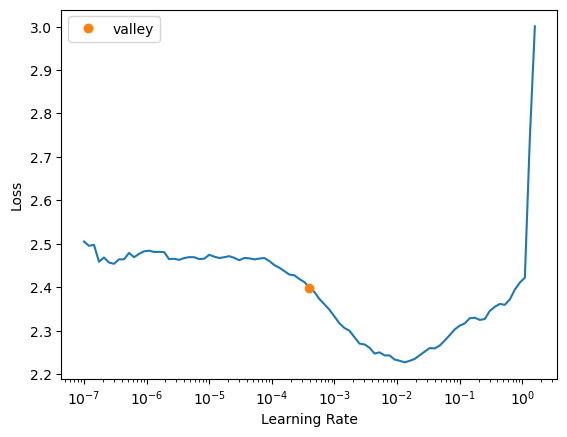

In [32]:
lr = learn.lr_find()

In [33]:
learn.fit_one_cycle(5, lr.valley)

## Progressive resizing

Note that as you continue training the model, the training loss will become quite a bit lower than the validation loss. Which is not in itself a problem, but there are tricks that can in a sense deal with this, and that can sometimes lead to better results.. Progressive resizing is one such trick.

By first training on a small version of the images and then progressively on larger and larger images one can often improve performance. In a sense you're pretraining the model on data that's very similar, yet different, to the target data set.

In [34]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            RandomErasing(), 
            RandomResizedCrop(128),
            Normalize.from_stats(*imagenet_stats)]

### Size 64x64

In [35]:
dls = get_dataloaders(sz=64, bs=128, batch_tfms=batch_tfms)

In [36]:
learn = Learner(
    dls, xresnet34(n_out=10),
    metrics=[accuracy, RocAuc(), F1Score(average='micro')], 
    path='.').to_fp16()

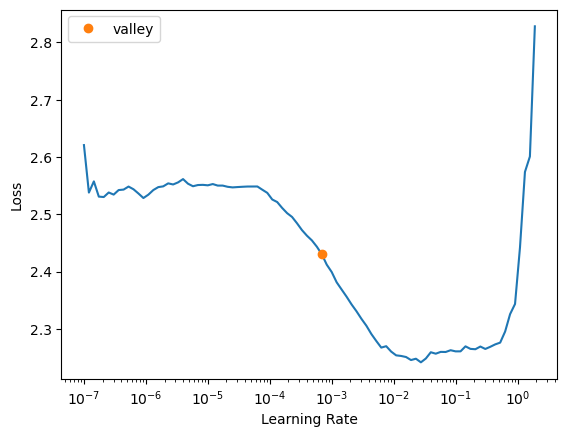

In [37]:
lr = learn.lr_find()

In [38]:
learn.fit_one_cycle(2, lr)

### Size 128x128

In [39]:
learn.dls = get_dataloaders(sz=128, bs=128, batch_tfms=batch_tfms)

In [40]:
learn.fit_one_cycle(8, lr)

## Here are the results of a version with more data augmentation

_Precomputed before the lecture as the training is time-consuming_

In [41]:
batch_tfms=[Contrast(), Flip(), Brightness(), Rotate(max_deg=10), Saturation(),
            Zoom(max_zoom=1.1, min_zoom=1.0, p=0.5),
            RandomErasing(), 
            RandomResizedCrop(128),
            Normalize.from_stats(*imagenet_stats)]

In [42]:
dls = get_dataloaders(sz=224, bs=128, batch_tfms=batch_tfms)

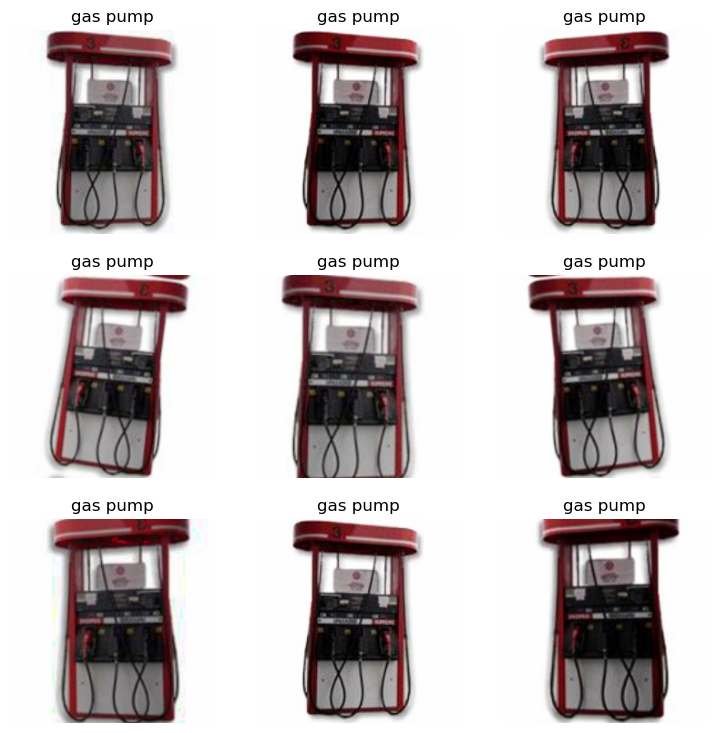

In [43]:
dls.show_batch(unique=True)

In [44]:
learn = Learner(
    dls, xresnet34(n_out=10),
    metrics=[accuracy, RocAuc(), F1Score(average='micro')], 
    path='.').to_fp16()

Here's the output of the training process (I ran it before the lecture):

<img src="assets/imagenette_mixup_training.png">

In [45]:
learn.fit_one_cycle(35, lr, cbs=[MixUp()])

In [63]:
#learn.save('mixup_model')

Path('models/mixup_model.pth')

In [64]:
learn.load('mixup_model')

# Evaluate

## TTA: Test-time augmentation

Here's a trick that can potentially improve predictions on test data: make multiple predictions per test image using the data augmentation set up during training to make several somewhat independent predictions per image:

In [65]:
y_pred, y_test = learn.tta(n=10)

In [66]:
print(accuracy(y_pred, y_test).item())

0.9111276865005493


## Confusion matrix

In [67]:
interp = ClassificationInterpretation.from_learner(learn)

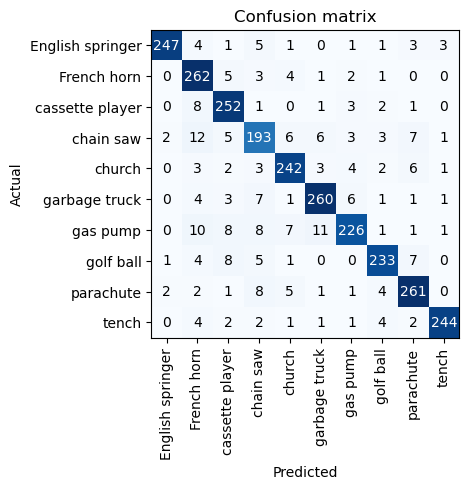

In [68]:
interp.plot_confusion_matrix()

## Most confused

In [69]:
interp.most_confused(min_val=8)

[('chain saw', 'French horn', 12),
 ('gas pump', 'garbage truck', 11),
 ('gas pump', 'French horn', 10),
 ('cassette player', 'French horn', 8),
 ('gas pump', 'cassette player', 8),
 ('gas pump', 'chain saw', 8),
 ('golf ball', 'cassette player', 8),
 ('parachute', 'chain saw', 8)]

## Class activation maps

By extracting the gradients belonging to each of the classes in the data set as they flow into the final convolutional layer in the image, one can produce a heatmap that indicates where in the image the model based its predictions on. 

<img src="assets/gradcam.png">

In [53]:
%pip install palettable fastai_amalgam matplotlib_venn

Note: you may need to restart the kernel to use updated packages.


In [54]:
# See the file `some_utils.py` to check what's imported here
# to compute the gradcam maps.
from some_utils import *

In [55]:
fnames

(#13394) [Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_954.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_4705.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1096.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_7594.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_2395.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1263.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_5156.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_1055.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_2644.JPEG'),Path('/home/ubuntu/.fastai/data/imagenette2-160/train/n02102040/n02102040_919.JPEG')...]

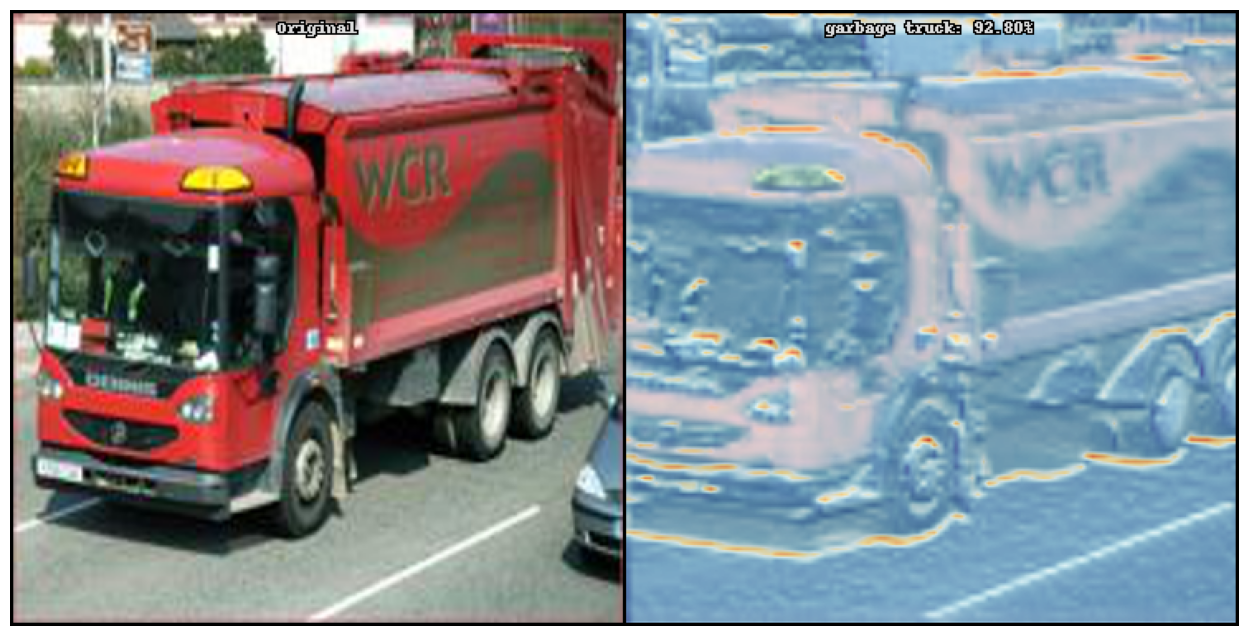

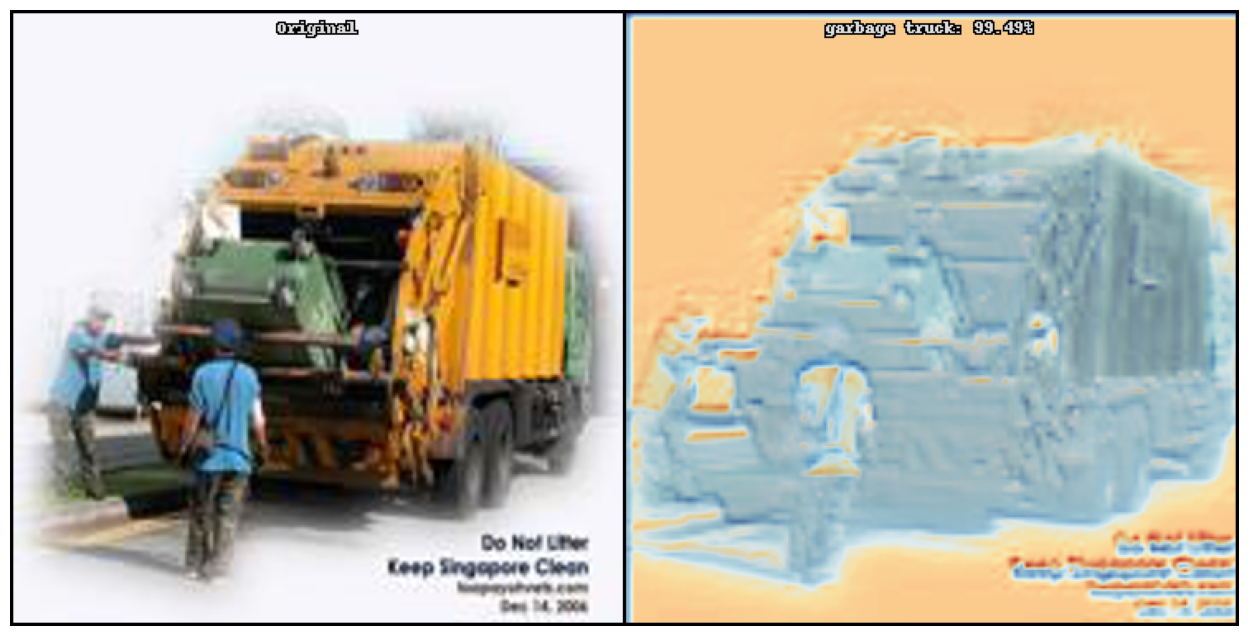

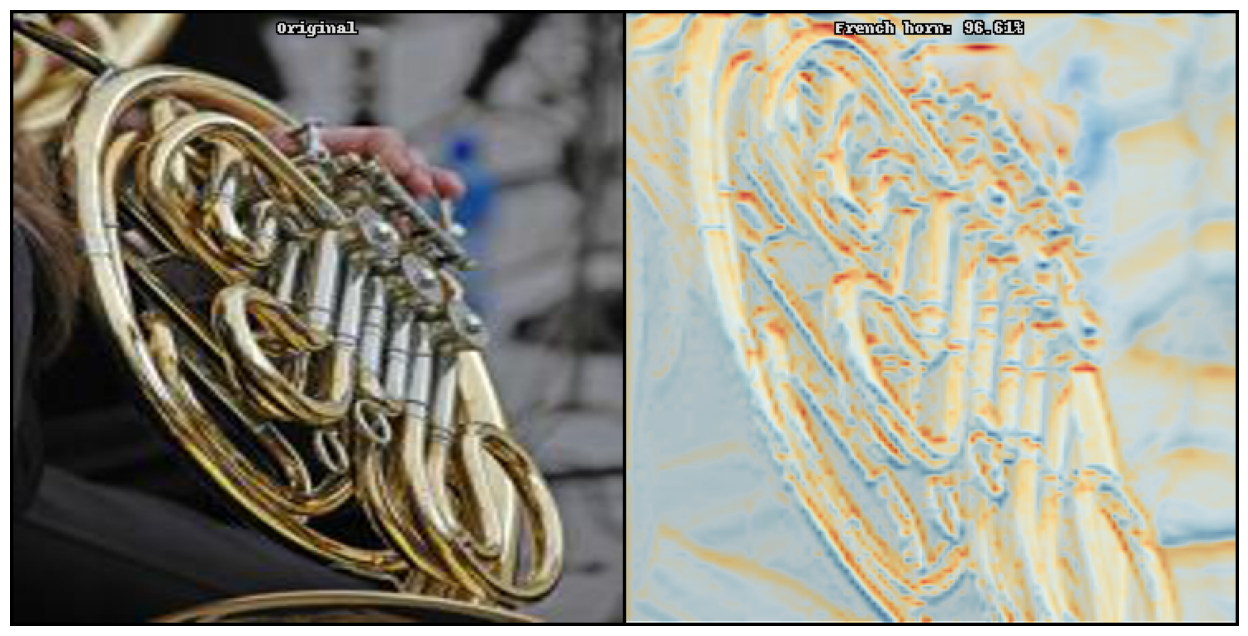

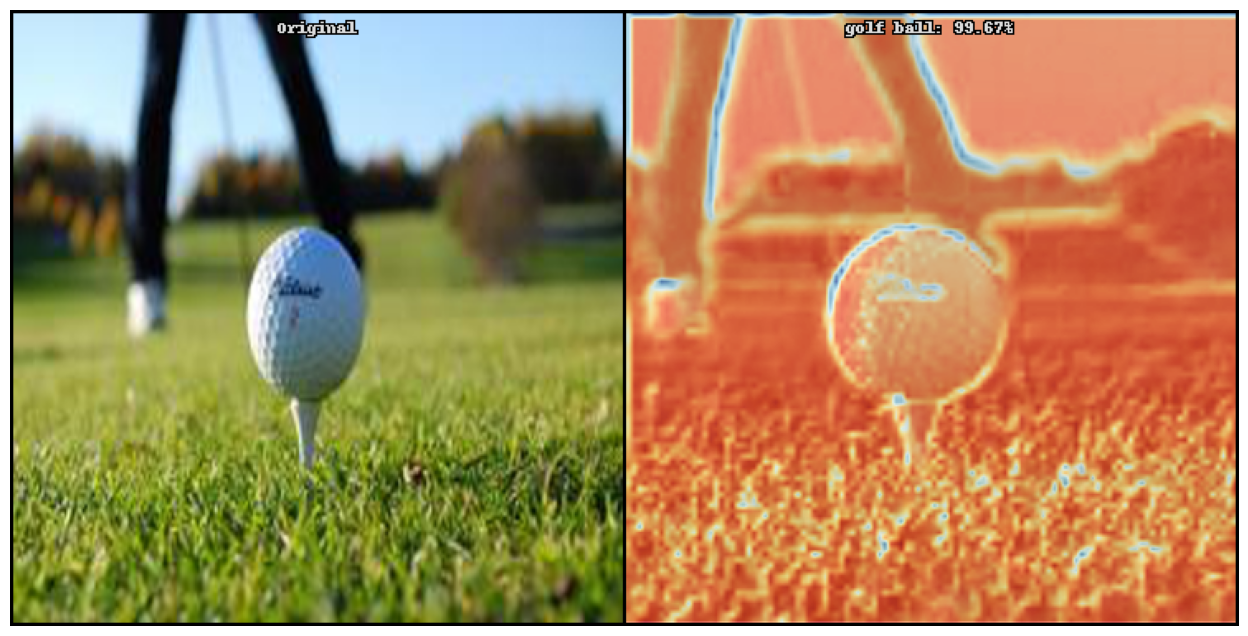

In [56]:
for img_fn in random.choices(fnames, k=4):
    gcam = gradcam(learn, img_fn, show_original=True, alpha=0.8)
    f = plt.figure(figsize=(16,8))
    plt.imshow(gcam)
    plt.axis('off')
    plt.show()

# Your turn!

Try to repeat the above story for the CIFAR-10 data set. How accurate a model are you able to construct?